In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import seaborn as sns

#### **Prepare dataset**

In [2]:
vcb = pd.read_csv('data/Vietcombank_statement.csv', dtype={'transaction_no':'string'}, parse_dates=['transaction_date'], date_format='%d/%m/%Y')
vtb = pd.read_csv('data/Vietinbank_statement.csv', parse_dates=['Ngày GD'])

# Transform Vietcombank data
vcb['credit'] = vcb['credit'].apply(lambda x: int(str(x).replace('.','')))

# Concatnate the 2 dataframes
vtb.columns = ['transaction_no', 'transaction_date', 'detail', 'credit', 'name']
vtb = vtb[['transaction_no', 'transaction_date', 'credit', 'detail']]

vcb['bank'] = 'Vietcombank'
vtb['bank'] = 'Vietinbank'

statement = pd.concat([vcb, vtb])
statement['transaction_date'] = statement['transaction_date'].dt.date

# Set buckets
buckets = ['<=50K', '51-100K', '101-500K', '501-1000K', '1-10M', '10-100M', '>100M']
bucket_flags = np.array([0,50,100,500,1000,10000,100000,np.inf])*1000
statement['bucket'] = pd.cut(statement['credit'], bins=bucket_flags, labels=buckets)

# Segmentize donators
def donator_segment(detail: str):
    detail = detail.lower()
    brands = ['cocoon', 'stressmama', 'actidem','empower you', 'hayari', 'ancungbatuyet', 'hhbhvn', 'honda', '2n1d', 'huelley']
    celebs = ['vo ha linh', 'huynh tran thanh', 'lo lem', 'nguyen quang hai', 'sofia']
    segment_map = {
        'family': ['gia dinh', 'family'],
        'student/school': ['truong', 'dai hoc', 'sinh vien', 'hoc sinh', ' sv', 'hssv', ' hs', 'thcs', 'thpt'],
        'celeb/fandom' : ['ca si', 'ca sy', 'nghe si', 'dien vien', 'rapper', 'fan', 'ham mo', 'fc', 'clb', ' dv ', '.dv ', 'exo'] + celebs,
        'company/group': ['cty', 'cong ty', 'ctcp', 'tnhh', 'tap the', 'tap doan', 'benh vien', 'hoc vien', 'bv ',
                          'doanh nghiep', 'doang nghiep', 'doi ngu', 'cong dong', 'team', 'group',
                          'ban to chuc', 'btc', '.dn ', 'corp', 'media', 'capital',
                          'phong thuy', 'shop', 'store', 'spa', 'logistic', 'bar'] + brands        
    }
    for item, keywords in segment_map.items():
        for keyword in keywords:
            if keyword in detail:
                return item
    return 'unknown'

statement['segment'] = statement['detail'].apply(donator_segment)

#### **EDA**

In [3]:
statement.credit.describe()

count    2.608530e+05
mean     6.519160e+05
std      4.997828e+06
min      2.000000e+01
25%      1.000000e+05
50%      2.000000e+05
75%      5.000000e+05
max      1.000000e+09
Name: credit, dtype: float64

In [4]:
# Group by Date
gb_date = statement.groupby('transaction_date', as_index=False).agg({'credit':['sum', 'count', 'mean', 'median']})
gb_date.columns = ['transaction_date', 'sum', 'count', 'mean', 'median']
gb_date['transaction_date'] = pd.to_datetime(gb_date['transaction_date'])
gb_date

,transaction_date,sum,count,mean,median
0,2024-09-01,149000,14,1.064286e+04,3000.0
1,2024-09-02,572000,5,1.144000e+05,10000.0
2,2024-09-03,1111000,9,1.234444e+05,100000.0
3,2024-09-04,7681000,42,1.828810e+05,6000.0
4,2024-09-05,1201888,32,3.755900e+04,6000.0
5,2024-09-06,1706000,34,5.017647e+04,8000.0
6,2024-09-07,6558000,58,1.130690e+05,8000.0
7,2024-09-08,885410201,503,1.760259e+06,100000.0
8,2024-09-09,7868744495,6279,1.253184e+06,200000.0
9,2024-09-10,126962106625,194916,6.513683e+05,200000.0


In [5]:
# Group by Bucket
gb_bucket = statement.groupby('bucket', as_index=False)['credit'].agg(['sum', 'count'])
gb_bucket['count_cont'] = gb_bucket['count'] / gb_bucket['count'].sum()
gb_bucket['cum_count_cont'] = gb_bucket['count_cont'].cumsum()
gb_bucket

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22052\1950982125.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb_bucket = statement.groupby('bucket', as_index=False)['credit'].agg(['sum', 'count'])


,bucket,sum,count,count_cont,cum_count_cont
0,<=50K,1297869755,37298,0.142985,0.142985
1,51-100K,5823584136,59003,0.226193,0.369177
2,101-500K,38824351022,121830,0.467045,0.836222
3,501-1000K,26539677845,27095,0.103871,0.940093
4,1-10M,52069962166,14593,0.055943,0.996036
5,10-100M,34048961981,991,0.003799,0.999835
6,>100M,11449836802,43,0.000165,1.000000


In [6]:
# Group by Segment
gb_segment = statement.groupby('segment')['credit'].agg(['sum', 'count', 'mean', 'median'])
gb_segment['total_cont'] = gb_segment['sum'] / gb_segment['sum'].sum()
gb_segment['count_cont'] = gb_segment['count'] / gb_segment['count'].sum()
gb_segment

,sum,count,mean,median,total_cont,count_cont
segment,,,,,,
celeb/fandom,5505805029,1876,2.934864e+06,200000.0,0.032377,0.007192
company/group,17430583647,1493,1.167487e+07,1111111.0,0.102500,0.005724
family,5441448547,3278,1.659990e+06,500000.0,0.031998,0.012566
student/school,2378423441,5357,4.439842e+05,100000.0,0.013986,0.020536
unknown,139297983043,248849,5.597691e+05,200000.0,0.819139,0.953982


In [7]:
# Distribution of segment with >100M bucket
statement[(statement['bucket']=='>100M')]['segment'].value_counts(normalize=True)

segment
company/group    0.395349
celeb/fandom     0.325581
unknown          0.232558
family           0.046512
Name: proportion, dtype: float64

In [8]:
# Group by Segment and Bucket
gb_segment_bucket = statement.groupby(['segment', 'bucket'], as_index=False)['credit'].agg(['sum', 'count', 'mean', 'median'])
gb_segment_bucket

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22052\2322652188.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gb_segment_bucket = statement.groupby(['segment', 'bucket'], as_index=False)['credit'].agg(['sum', 'count', 'mean', 'median'])


,segment,bucket,sum,count,mean,median
0,celeb/fandom,<=50K,11582528,331,3.499253e+04,50000.0
1,celeb/fandom,51-100K,38959211,396,9.838185e+04,100000.0
2,celeb/fandom,101-500K,203001122,675,3.007424e+05,220590.0
3,celeb/fandom,501-1000K,150912637,165,9.146220e+05,1000000.0
4,celeb/fandom,1-10M,808018685,253,3.193750e+06,2000000.0
5,celeb/fandom,10-100M,1458920011,42,3.473619e+07,20000000.0
6,celeb/fandom,>100M,2834410835,14,2.024579e+08,200000000.0
7,company/group,<=50K,2484111,94,2.642671e+04,20000.0
8,company/group,51-100K,9628760,98,9.825265e+04,100000.0
9,company/group,101-500K,100077840,285,3.511503e+05,300000.0


In [22]:
len(statement[statement['credit']<=10**6]) / len(statement)

0.9400926958861888

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22052\2847237539.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(range(0,10**7,5*10**5), rotation=90, fontsize=8)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22052\2847237539.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(range(0,10**7,5*10**5), rotation=90, fontsize=8)


(0.0, 5000000.0)

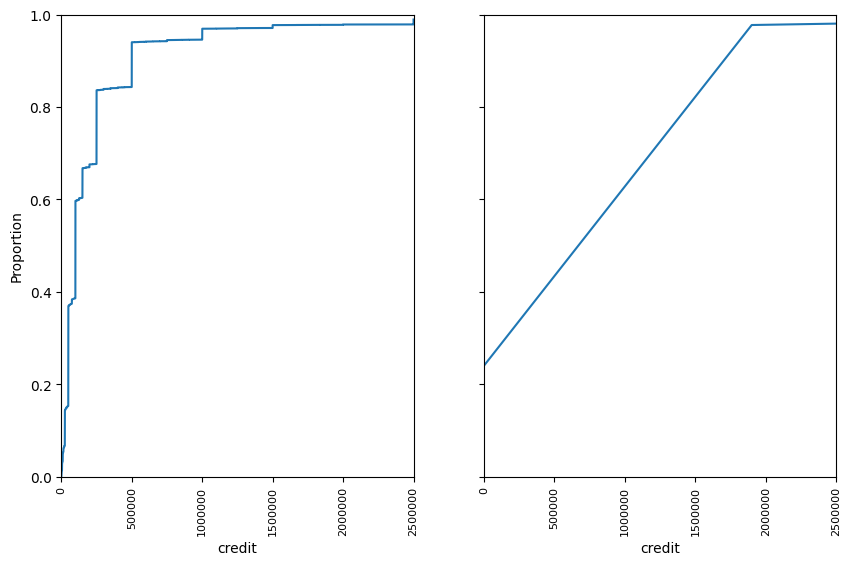

In [29]:
fig, ax = plt.subplots(figsize=(10,6), ncols=2, sharey=True)
sns.ecdfplot(data=statement, x='credit', ax=ax[0])
ax[0].set_xticklabels(range(0,10**7,5*10**5), rotation=90, fontsize=8)
ax[0].set_xlim(0, 5*10**6)

sns.kdeplot(data=statement, x='credit', cumulative=True, ax=ax[1])
ax[1].set_xticklabels(range(0,10**7,5*10**5), rotation=90, fontsize=8)
ax[1].set_xlim(0, 5*10**6)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_22052\1597685686.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1][0].set_xticklabels(gb_bucket['bucket'])


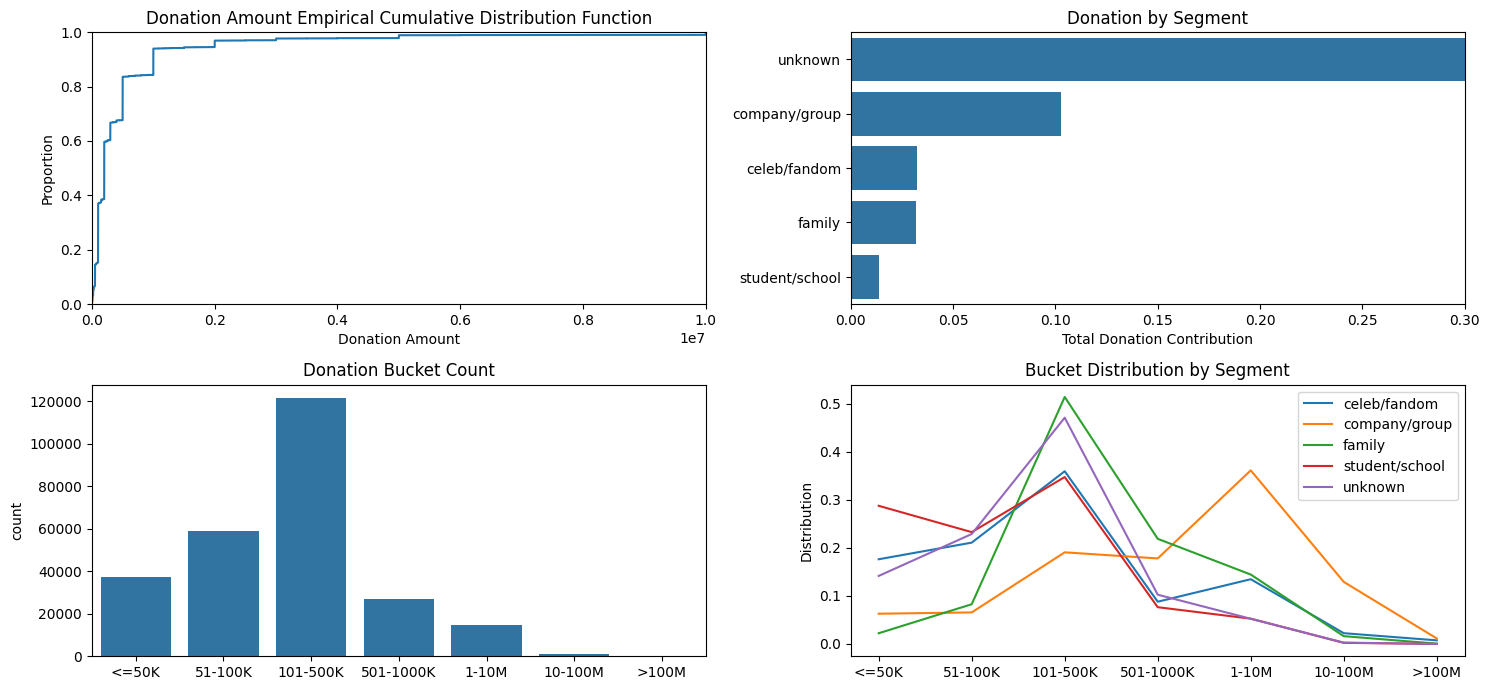

In [31]:
# Create subplots with two rows
fig, ax = plt.subplots(figsize=(15, 7), nrows=2, ncols=2)

# Empirical Cumulative Distribution Function plot on the second subplot
sns.ecdfplot(data=statement, x='credit', ax=ax[0][0])
ax[0][0].set_xlim(0, 10**7)
ax[0][0].set_xlabel('Donation Amount')
ax[0][0].set_title('Donation Amount Empirical Cumulative Distribution Function')

# Bar plot on the first subplot
sns.barplot(data=gb_segment.sort_values('total_cont', ascending=False), x='total_cont', y='segment', ax=ax[0][1])
ax[0][1].set_xlim(0,0.3)
ax[0][1].set_xlabel('Total Donation Contribution')
ax[0][1].set_ylabel(None)
ax[0][1].set_title('Donation by Segment')

# Plot Bucket Count
sns.barplot(data=gb_bucket, x='bucket', y='count', ax=ax[1][0])
ax[1][0].set_xticklabels(gb_bucket['bucket'])
ax[1][0].set_title('Donation Bucket Count')
ax[1][0].set_xlabel(None)

# Plot Bucket distribution by Segment
for sgm in gb_segment_bucket.segment.unique():
    is_sgm = gb_segment_bucket.segment == sgm
    gb_segment_bucket.loc[is_sgm, 'count_cont'] = gb_segment_bucket[is_sgm]['count'] / gb_segment_bucket[is_sgm]['count'].sum()
    ax[1][1].plot(gb_segment_bucket.loc[is_sgm, 'bucket'], gb_segment_bucket.loc[is_sgm, 'count_cont'], label=sgm)
ax[1][1].set_ylabel('Distribution')
ax[1][1].legend()
ax[1][1].set_title('Bucket Distribution by Segment')

# Adjust layout to avoid overlapping titles and labels
plt.tight_layout()

plt.savefig('charts.jpg')
# Show the plot
plt.show()

In [10]:
for seg in statement.segment.unique():
    is_segment = statement['segment'] == seg
    maxcredit = statement.loc[is_segment, 'credit'].max()
    print(f'\nSegment: {seg}', f'\nMaximum donation: {maxcredit:,}')
    print(statement[is_segment & (statement.credit == maxcredit)]['detail'].values)


Segment: unknown 
Maximum donation: 300,000,000
['398155.100924.174901.DUY CHINH ung ho Dong Bao khac phuc lu lut bao Yagi.']

Segment: family 
Maximum donation: 200,000,000
['900B2490GMZ9ESG1/HUNG & GIA DINH O 134/1/12A CACH MANG THANG 8, Q3 KINH UNG HO SAU BAO YAGI (CT1111)']

Segment: student/school 
Maximum donation: 30,000,000
['821643.100924.070303.Truong MN Kitten ung ho cuu tro cac tinh, thanh pho thiet hai do con bao bao Yagi gay ra']

Segment: celeb/fandom 
Maximum donation: 400,000,000
['MBVCB.6997056113.Hoa Minzy cung FC xin duoc ung ho ba con bi thiet hai do bao Yagi.CT tu 0881000956868 NGUYEN THI HOA toi 0011001932418 MAT TRAN TO QUOC VN - BAN CUU TRO TW']

Segment: company/group 
Maximum donation: 1,000,000,000
['SHGD:10004067.DD:240910.BO:VAN PHONG HOC VIEN CHINH TRI QUOC GIA HC.Remark:HV CTQG HOCHIMINH UNG HO LE PHATDONG UNG HO DONGBAO BI THIET HAI DO BAO SO 3GAY RA'
 'BENH VIEN DA KHOA QUOC TE THU CUC TCI DONG GOP VAO QUY HO TRO DONG BAO VUNG BAO YAGI VA LU LUT. CAU 